# **Implementación de modelo computacional**

Este código ejecuta un modelo de detección de residuos en imágenes entrenado en tensorflow y un algoritmo que permite calcular el porcentaje de área contaminada por los residuos por medio de Anaconda o a través de un script de python, se utiliza Tensorflow en una versión 2.X.

In [ ]:

import os
import cv2
import csv
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util

def cargar_modelo(ruta_modelo):
    return tf.saved_model.load(ruta_modelo)

def cargar_etiquetas(ruta_etiquetas):
    return label_map_util.create_category_index_from_labelmap(ruta_etiquetas, use_display_name=True)

def procesar_detecciones(detections, umbral_confianza=0.4):
    if detections is not None and 'detection_scores' in detections:
        detecciones_filtradas = detections['detection_scores'][0] > umbral_confianza
        num_detecciones = np.sum(detecciones_filtradas)
        return num_detecciones > 0, num_detecciones
    else:
        return False, 0

def calcular_porcentaje_ocupacion(ruta_imagen):
    imagen_entrada = cv2.imread(ruta_imagen)
    #Identificación de los residuos mediante segmentación por color
    imagen_filtrada = cv2.bilateralFilter(imagen_entrada, 15, 140, 140)
    imagen_hsv = cv2.cvtColor(imagen_filtrada, cv2.COLOR_BGR2HSV)
    blanco_inferior = np.array([0, 0, 200])
    blanco_superior = np.array([255, 45, 255])
    azul_inferior = np.array([100, 50, 50])
    azul_superior = np.array([270, 255, 255])
    rojo_inferior = np.array([0, 146, 110])
    rojo_superior = np.array([30, 217, 243])
    mascara_blanca = cv2.inRange(imagen_hsv, blanco_inferior, blanco_superior)
    mascara_azul = cv2.inRange(imagen_hsv, azul_inferior, azul_superior)
    mascara_roja = cv2.inRange(imagen_hsv, rojo_inferior, rojo_superior)
    mask = cv2.bitwise_or(mascara_blanca, mascara_azul)
    mask = cv2.bitwise_or(mask, mascara_roja)
    imagen_salida = cv2.bitwise_and(imagen_filtrada, imagen_filtrada, mask=mask)
    filtro = cv2.GaussianBlur(imagen_salida, (5, 5), 0)
    gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
    _,binary = cv2.threshold(gray, 35, 255, cv2.THRESH_BINARY)
    #Operaciones morfológicas
    kernel = np.ones((5, 5), np.uint8)
    dilatacion = cv2.dilate(binary, kernel, iterations=1)
    erosion = cv2.erode(dilatacion, kernel, iterations=1)
    cierre = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
    # Conteo de píxeles del objeto, countNonZero()  devuelve el número de píxeles distintos de cero
    num_pixeles_objeto = cv2.countNonZero(cierre)
    # Área de un solo píxel (suponiendo que la imagen tiene 1 canal)
    area_un_pixel = 1.0
    # Cálculo del área ocupada por el objeto
    area_ocupada_residuo = num_pixeles_objeto * area_un_pixel
    # Ingrese las dimensiones de la imagen
    ancho=224
    alto=224
    area_imagen=ancho*alto
    porcentaje_ocupacion=(area_ocupada_residuo*100)/area_imagen
    return porcentaje_ocupacion

def procesar_imagen(modelo, etiquetas, ruta_imagen):
    image_np = cv2.imread(ruta_imagen)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = modelo(input_tensor)

    hay_detecciones, num_detecciones = procesar_detecciones(detections)

    if hay_detecciones:
        total_pixeles = image_np.shape[0] * image_np.shape[1]
        porcentaje_ocupacion = calcular_porcentaje_ocupacion(ruta_imagen)

        return {'Imagen': ruta_imagen, 'Residuos Detectados': num_detecciones, 'Nivel de contaminacion (%)': porcentaje_ocupacion}
    else:
        return None

if __name__ == "__main__":
    PATH_TO_SAVED_MODEL = r'C:\Users\equipo\modelos\exported-models\ssd_mobnet_v2\exported_models\saved_model'
    PATH_TO_LABELS = r'C:\Users\equipo\modelos\annotations\label_map.pbtxt'
    CARPETA_DE_IMAGENES = r'imagenes'
    OUTPUT_CSV = r'C:\Users\equipo\Documents\Implementacion_prueba\Resultados.csv'

    modelo = cargar_modelo(PATH_TO_SAVED_MODEL)
    etiquetas = cargar_etiquetas(PATH_TO_LABELS)

    resultados = []

    for nombre_archivo in os.listdir(CARPETA_DE_IMAGENES):
        if nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            ruta_imagen = os.path.join(CARPETA_DE_IMAGENES, nombre_archivo)

            resultados_imagen = procesar_imagen(modelo, etiquetas, ruta_imagen)

            if resultados_imagen:
                resultados.append(resultados_imagen)

    # Guardar los resultados en un único archivo CSV
    with open(OUTPUT_CSV, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Imagen', 'Residuos Detectados', 'Nivel de contaminacion (%)'])
        writer.writeheader()
        writer.writerows(resultados)

# **Implementación de modelo computacional en una Rapberry Pi 3B+**

Este código ejecuta un modelo de detección de residuos en imágenes entrenado en tensorflow y un algoritmo que permite calcular el porcentaje de área contaminada por los residuos por medio de una Raspberry pi.

In [ ]:
import os
import cv2
import csv
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

In [ ]:
import os
import cv2
import csv
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

def cargar_modelo(ruta_modelo):
    return tf.saved_model.load(ruta_modelo)

def cargar_etiquetas(ruta_etiquetas):
    return label_map_util.create_category_index_from_labelmap(ruta_etiquetas, use_display_name=True)

def procesar_detecciones(detections, umbral_confianza=0.3):
    if detections is not None and 'detection_scores' in detections:
        detecciones_filtradas = detections['detection_scores'][0] > umbral_confianza
        num_detecciones = np.sum(detecciones_filtradas)
        return num_detecciones > 0, num_detecciones
    else:
        return False, 0

def calcular_porcentaje_ocupacion(num_detecciones, total_pixeles):
    # Lógica para calcular el porcentaje de ocupación
    # Asume que tienes la lógica necesaria para calcular esto
    # Puedes implementar tu propio cálculo basado en tu algoritmo
    porcentaje_ocupacion = num_detecciones * 10 / total_pixeles  # Alguna lógica de cálculo ficticia
    return porcentaje_ocupacion

def procesar_imagen(modelo, etiquetas, ruta_imagen):
    image_np = cv2.imread(ruta_imagen)

    if image_np is not None:
        input_tensor = tf.convert_to_tensor(image_np)
        input_tensor = input_tensor[tf.newaxis, ...]

        detections = modelo(input_tensor)

        print("Detections:", detections)  # Agrega esta línea para imprimir las detecciones

        hay_detecciones, num_detecciones = procesar_detecciones(detections)

        if hay_detecciones:
            total_pixeles = image_np.shape[0] * image_np.shape[1]
            porcentaje_ocupacion = calcular_porcentaje_ocupacion(num_detecciones, total_pixeles)

            # Guardar los resultados en un archivo CSV
            with open(OUTPUT_CSV, 'w', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=['Imagen', 'Residuos Detectados', 'Porcentaje de Ocupación'])
                writer.writeheader()
                writer.writerow({'Imagen': ruta_imagen, 'Residuos Detectados': num_detecciones, 'Porcentaje de Ocupación': porcentaje_ocupacion})
    else:
        print(f"No se pudo cargar la imagen en {ruta_imagen}")

if __name__ == "__main__":
    PATH_TO_SAVED_MODEL = r'C:\Users\equipo\modelos\exported-models\ssd_mobnet_v2_fpnlite\saved_model'
    PATH_TO_LABELS = r'C:\Users\equipo\modelos\annotations\label_map.pbtxt'
    PATH_TO_IMAGE = r'C:\Users\equipo\Documents\crhistian\Proyecto\Dataset_Final\test\042716imagen_1110.jpg'
    OUTPUT_CSV = r'C:\Users\equipo\Documents\crhistian\Proyecto\Resultados_nov19\resultados.csv'

    modelo = cargar_modelo(PATH_TO_SAVED_MODEL)
    etiquetas = cargar_etiquetas(PATH_TO_LABELS)

    procesar_imagen(modelo, etiquetas, PATH_TO_IMAGE)

Detections: {'detection_multiclass_scores': <tf.Tensor: shape=(1, 100, 2), dtype=float32, numpy=
array([[[0.0032345 , 0.47771657],
        [0.01110964, 0.43066403],
        [0.00735801, 0.38344985],
        [0.00499005, 0.35880074],
        [0.00798766, 0.3498619 ],
        [0.00654023, 0.30170643],
        [0.00530964, 0.29225823],
        [0.00523043, 0.24314162],
        [0.00412522, 0.22900735],
        [0.00751221, 0.22652932],
        [0.00575271, 0.22515282],
        [0.00505034, 0.2153222 ],
        [0.00655804, 0.20043662],
        [0.00408112, 0.19539283],
        [0.00484405, 0.18679763],
        [0.00371901, 0.18520217],
        [0.00594453, 0.18482019],
        [0.00515596, 0.1830581 ],
        [0.00458579, 0.18253642],
        [0.00668404, 0.17480454],
        [0.00287519, 0.17229208],
        [0.0054077 , 0.17165646],
        [0.00323748, 0.16989586],
        [0.00686489, 0.16609012],
        [0.00446263, 0.16551886],
        [0.00439095, 0.15829977],
        [0.00410108

El resultado de ejecutar estos códigos de programación es un archivo csv con tres columnas, en la primera columna se identifica el nombre de la imagen, en la segunda columna el número de residuos detectados y en la tercera columna el porcentaje de área contaminada por la presencia de residuos.

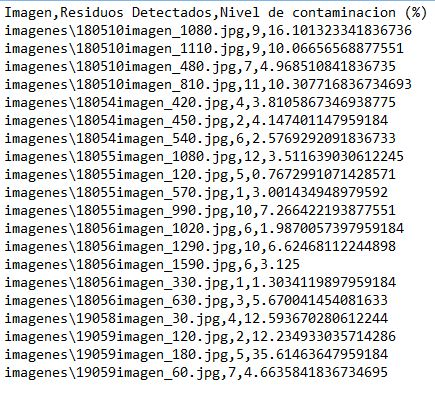